### Библиотеки

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
import itertools
from tqdm import tqdm

import statsmodels.api as sm
from scipy.stats import t, f, boxcox, skew, kurtosis, gmean
from statsmodels.stats.diagnostic import linear_reset, het_white
from linearmodels.iv import IV2SLS, compare

import warnings
warnings.filterwarnings('ignore')

### Обработка

In [2]:
data = pd.read_csv('Data_with_new_feature.csv', encoding='utf-8')

### Логарифм цены

In [3]:
data['log_price'] = np.log(data['price'])
data = data.drop(['price'], axis=1)
y = data['log_price']
X = data.drop(['log_price'], axis=1)

### Регрессоры, которые можно логарифмировать и нет

In [4]:
cols_to_try_log = ['avg_rating', 'tirage', 'cnt_reviews', 'pages_cnt']
unconditional_cols = [x for x in X.columns.tolist() if x not in cols_to_try_log]

In [5]:
def generate_all_combinations(num_of_repeats):
    """Генерирует все комбинации признаков, к которым применяется функциональное преобразование"""
    return product([False, True], repeat=num_of_repeats)

def prepare_X(cols_to_try_func, combination, df, func, flag='stay'):
    """Создает матрицу X для текущей комбинации"""
    """Примеры функций: np.log, np.power, np.reciprocal, ..."""
    X_temp = df[unconditional_cols].copy()
    feature_name = getattr(func, '__name__', repr(func))
    
    for i, col in enumerate(cols_to_try_func): # col = 'tirage'
        if combination[i]:
            try:
                safe_col = df[col]
                if (safe_col <= 0).any() and (func == np.log) or (func == np.reciprocal):
                    safe_col = safe_col + 1e-6
                if flag == 'stay':
                    X_temp[col] = safe_col
                    X_temp[f'{feature_name}_{col}'] = func(safe_col)
                else:
                    X_temp[f'{feature_name}_{col}'] = func(safe_col)
            except Exception as e:
                print(f"Ошибка при применении функции к {col}: {e}")
        else:
            X_temp[col] = df[col]
    
    return sm.add_constant(X_temp)

def getting_statistic(cols_to_try_func, df, func, flag='stay'):
    results = []

    total_combinations = 2 ** len(cols_to_try_func)
    feature_name = getattr(func, '__name__', repr(func))

    for combination in tqdm(generate_all_combinations(num_of_repeats=len(cols_to_try_func)), total=total_combinations):
        try:
            # Подготавливаем данные
            X_curr = prepare_X(cols_to_try_func, combination, df, func, flag=flag)

            model = sm.OLS(df['log_price'], X_curr).fit()
            results.append({
                'combination': combination,
                'aic': model.aic,
                'bic': model.bic,
                'adj_r2': model.rsquared_adj,
            })

        except Exception as e:
            print(f"Error in combination {combination}: {str(e)}")
            continue

    df_results = pd.DataFrame(results)

    df_results[f'{feature_name}_columns'] = df_results['combination'].apply(
        lambda x: [cols_to_try_func[i] for i, my_func in enumerate(x) if my_func]
    )
    
    return df_results

In [6]:
def custom_func(x):
    return x**2

In [7]:
my_func = np.log
data_frame = getting_statistic(cols_to_try_func=cols_to_try_log, df=data, func=my_func, flag='')

best_aic = data_frame.loc[data_frame['aic'].idxmin()]
best_bic = data_frame.loc[data_frame['bic'].idxmin()]
best_adj_r2 = data_frame.loc[data_frame['adj_r2'].idxmax()]

print("Лучшая модель по AIC:")
print(f"Логарифмированные переменные: {best_aic[f'{my_func.__name__}_columns']}")
print(f"AIC: {best_aic['aic']:.2f}\n")

print("Лучшая модель по BIC:")
print(f"Логарифмированные переменные: {best_bic[f'{my_func.__name__}_columns']}")
print(f"BIC: {best_bic['bic']:.2f}\n")

print("Лучшая модель по Adj.R²:")
print(f"Логарифмированные переменные: {best_adj_r2[f'{my_func.__name__}_columns']}")
print(f"Adj.R²: {best_adj_r2['adj_r2']:.4f}")

100%|██████████| 16/16 [00:00<00:00, 59.23it/s]

Лучшая модель по AIC:
Логарифмированные переменные: ['tirage']
AIC: 514.64

Лучшая модель по BIC:
Логарифмированные переменные: ['tirage']
BIC: 599.59

Лучшая модель по Adj.R²:
Логарифмированные переменные: ['tirage']
Adj.R²: 0.7287


**Вывод:** нужно логарифмировать тираж; Adj R^2 = 0.6062

**Логарифмирование тиража:**

In [8]:
upd_data = data.copy()
upd_data['log_tirage'] = np.log(upd_data['tirage'])
upd_data = upd_data.drop(['tirage'], axis=1)
upd_data.head()

,const,avg_rating,cnt_reviews,pages_cnt,publisher_АСТ,publisher_Азбука,publisher_Иностранка,publisher_Эксмо,cover_type_Твёрдый_переплёт,weight/page_cnt,2024_or_2025,6-,16+,log_price,log_tirage
0,1.0,4.1,925,512,1.0,0.0,0.0,0.0,0.0,0.488281,1.0,0.0,1.0,5.743003,10.308953
1,1.0,4.1,1341,320,1.0,0.0,0.0,0.0,0.0,0.625000,1.0,0.0,1.0,5.743003,10.308953
2,1.0,4.5,363,192,1.0,0.0,0.0,0.0,0.0,0.687500,1.0,0.0,1.0,5.648974,10.126631
3,1.0,4.3,872,288,1.0,0.0,0.0,0.0,0.0,0.725694,1.0,0.0,1.0,5.826000,9.392662
4,1.0,4.2,3004,320,1.0,0.0,0.0,0.0,0.0,0.625000,1.0,0.0,1.0,5.648974,10.308953


In [9]:
X_upd = upd_data.drop(['log_price'], axis=1)

In [10]:
X_upd

,const,avg_rating,cnt_reviews,pages_cnt,publisher_АСТ,publisher_Азбука,publisher_Иностранка,publisher_Эксмо,cover_type_Твёрдый_переплёт,weight/page_cnt,2024_or_2025,6-,16+,log_tirage
0,1.0,4.1,925,512,1.0,0.0,0.0,0.0,0.0,0.488281,1.0,0.0,1.0,10.308953
1,1.0,4.1,1341,320,1.0,0.0,0.0,0.0,0.0,0.625000,1.0,0.0,1.0,10.308953
2,1.0,4.5,363,192,1.0,0.0,0.0,0.0,0.0,0.687500,1.0,0.0,1.0,10.126631
3,1.0,4.3,872,288,1.0,0.0,0.0,0.0,0.0,0.725694,1.0,0.0,1.0,9.392662
4,1.0,4.2,3004,320,1.0,0.0,0.0,0.0,0.0,0.625000,1.0,0.0,1.0,10.308953
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3185,1.0,5.0,3,624,0.0,0.0,0.0,1.0,1.0,1.538462,0.0,0.0,1.0,7.313220
3186,1.0,3.7,53,448,0.0,0.0,0.0,1.0,1.0,1.696429,0.0,0.0,1.0,7.313220
3187,1.0,4.3,42,784,0.0,0.0,1.0,0.0,1.0,1.096939,0.0,0.0,1.0,8.006368
3188,1.0,3.8,29,704,0.0,0.0,0.0,1.0,1.0,0.906250,0.0,0.0,1.0,7.600902


In [11]:
# cols_to_try_log_ = ['avg_rating', 'cnt_reviews', 'pages_cnt']
# unconditional_cols_ = [x for x in X_try.columns.tolist() if x not in cols_to_try_log_]

Также функции будут работать, если мы решим проверить какие-то кастомные функции типо этого:

### Итоговая модель с ln Y

После проверки всех функциональных форм обучаем итоговую модель:

In [12]:
log_model = sm.OLS(data['log_price'], X_upd).fit()
print(log_model.summary())

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.730
Model:                            OLS   Adj. R-squared:                  0.729
Method:                 Least Squares   F-statistic:                     660.0
Date:                Thu, 08 May 2025   Prob (F-statistic):               0.00
Time:                        23:32:29   Log-Likelihood:                -243.32
No. Observations:                3190   AIC:                             514.6
Df Residuals:                    3176   BIC:                             599.6
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

## Тест Рамсея

In [13]:
reset_result = linear_reset(log_model, power=2)

print("RESET test (Ramsey)")
print(reset_result)

RESET test (Ramsey)
<Wald test (chi2): statistic=372.8981397925422, p-value=4.377093274505311e-83, df_denom=1>


**Вывод:** отвергаем H0 ==> нужно добавить степени

In [14]:
X_ramsey = X_upd.copy()
X_ramsey['Y_hat^2'] = log_model.fittedvalues**2
X_ramsey['Y_hat^3'] = log_model.fittedvalues**3
X_ramsey['Y_hat^4'] = log_model.fittedvalues**4
X_ramsey['Y_hat^5'] = log_model.fittedvalues**5

In [15]:
log_model = sm.OLS(data['log_price'], X_ramsey).fit()
print(log_model.summary())

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.813
Method:                 Least Squares   F-statistic:                     816.9
Date:                Thu, 08 May 2025   Prob (F-statistic):               0.00
Time:                        23:32:29   Log-Likelihood:                 352.50
No. Observations:                3190   AIC:                            -669.0
Df Residuals:                    3172   BIC:                            -559.8
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

In [16]:
reset_result = linear_reset(log_model, power=2)

print("RESET test (Ramsey)")
print(reset_result)

RESET test (Ramsey)
<Wald test (chi2): statistic=264.1292287221383, p-value=2.160078767658819e-59, df_denom=1>


In [17]:
# Тест Уайта
residuals = log_model.resid
white_test = het_white(residuals, X_upd)

lm_stat, lm_pval, f_stat, f_pval = white_test

print(f"LM-статистика: {lm_stat}")
print(f"p-value для LM-статистики: {lm_pval}")
print(f"F-статистика: {f_stat}")
print(f"p-value для F-статистики: {f_pval}")

if lm_pval < 0.05:
    print("Гетероскедастичность выявлена.")
else:
    print("Нет признаков гетероскедастичности.")

LM-статистика: 848.698483708599
p-value для LM-статистики: 2.939458512262411e-125
F-статистика: 12.924644926505323
p-value для F-статистики: 1.3749319353349965e-149
Гетероскедастичность выявлена.


In [18]:
# Тест Глейзера
abs_residuals = np.abs(residuals)
glejser_model = sm.OLS(abs_residuals, X_upd).fit()

p_values = glejser_model.pvalues
# print(f"P-значения:")
# if p_values[0]:
#     print(p_values)
if any(p < 0.05 for p in p_values[1:]):
    print("Есть признаки гетероскедастичности.")
else:
    print("Нет признаков гетероскедастичности.")

Есть признаки гетероскедастичности.


In [19]:
data_sorted = data.sort_values(by='cover_type_Твёрдый_переплёт', ascending=True).reset_index(drop=True)
last_soft_index = data_sorted[data_sorted['cover_type_Твёрдый_переплёт'] == 0].index[-1]
print("Последний индекс с мягкой обложкой (0):", last_soft_index)
data_sorted

Последний индекс с мягкой обложкой (0): 1518


,const,avg_rating,cnt_reviews,pages_cnt,tirage,publisher_АСТ,publisher_Азбука,publisher_Иностранка,publisher_Эксмо,cover_type_Твёрдый_переплёт,weight/page_cnt,2024_or_2025,6-,16+,log_price
0,1.0,4.1,925,512,30000,1.0,0.0,0.0,0.0,0.0,0.488281,1.0,0.0,1.0,5.743003
1,1.0,5.0,2,352,4000,0.0,1.0,0.0,0.0,0.0,0.511364,0.0,0.0,1.0,5.713733
2,1.0,4.5,65,352,4000,0.0,0.0,0.0,1.0,0.0,0.482955,1.0,0.0,1.0,5.680173
3,1.0,4.1,31,416,3000,1.0,0.0,0.0,0.0,0.0,0.502404,0.0,0.0,0.0,5.648974
4,1.0,4.3,69,352,3000,0.0,1.0,0.0,0.0,0.0,0.482955,0.0,0.0,1.0,5.700444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3185,1.0,4.8,12,352,3000,1.0,0.0,0.0,0.0,1.0,0.880682,0.0,1.0,0.0,6.466145
3186,1.0,4.2,317,544,3000,0.0,0.0,1.0,0.0,1.0,1.231618,1.0,0.0,1.0,6.963190
3187,1.0,4.9,10,544,3000,0.0,0.0,1.0,0.0,1.0,0.937500,1.0,0.0,1.0,6.660575
3188,1.0,4.9,17,896,4000,0.0,1.0,0.0,0.0,1.0,1.160714,1.0,0.0,1.0,7.123673


In [20]:
data_sorted.columns

Index(['const', 'avg_rating', 'cnt_reviews', 'pages_cnt', 'tirage',
       'publisher_АСТ', 'publisher_Азбука', 'publisher_Иностранка',
       'publisher_Эксмо', 'cover_type_Твёрдый_переплёт', 'weight/page_cnt',
       '2024_or_2025', '6-', '16+', 'log_price'],
      dtype='object')

## Тест Чоу

Одной из причин гетероскедастичности может быть факт разнородности данных. Для того, чтобы проверить, в этом ли проблема, проведем тест Чоу.

**Выбор бинарной переменной для деления данных и проведения теста Чоу.**<br>

Тип обложки (твёрдая или мягкая) является возможным источником потенциальной разнородности. Книги в твёрдом переплёте, как правило, позиционируются как более премиальный продукт: они дороже в производстве, дольше служат и часто сопровождаются более высоким качеством бумаги и печати. Цена таких изданий формируется иначе, чем у книг в мягкой обложке, где ключевым фактором становится доступность и массовость. Это различие может приводить к тому, что одни и те же характеристики (например, объём, рейтинг или тираж) по-разному влияют на цену в зависимости от типа обложки. Кроме того, дисперсия ошибок модели может отличаться: для твёрдых обложек разброс цен может быть выше из-за большего диапазона качества и маркетинговых стратегий. В связи с этим деление выборки по типу обложки обосновано как с точки зрения различий в структуре ценообразования, так и возможной гетероскедастичности между группами.

Составим три модели:

\begin{align*}
\textbf{(1) } \ln(\text{price}_i) &= \beta_1 + \beta_2 \cdot \text{avg_rating}_i + \beta_3 \cdot \text{cnt_reviews}_i + \beta_4 \cdot \text{pages_cnt}_i + \beta_5 \cdot \text{tirage}_i \\
&\quad + \beta_6 \cdot \text{publisher_АСТ}_i + \beta_7 \cdot \text{publisher_Азбука}_i + \beta_8 \cdot \text{publisher_Иностранка}_i + \beta_9 \cdot \text{publisher_Эксмо}_i \\
&\quad + \beta_{10} \cdot \text{cover_type_Твёрдый_переплёт}_i + \beta_{11} \cdot \left( \frac{\text{weight}}{\text{page_cnt}} \right)_i + \beta_{12} \cdot \text{2024_or_2025}_i \\
&\quad + \beta_{13} \cdot \text{6-}_i + \beta_{14} \cdot \text{16+}_i, \quad \text{где } i = 0, \dots, 1518
\end{align*}

\begin{align*}
\textbf{(2) } \ln(\text{price}_j) &= \alpha_1 + \alpha_2 \cdot \text{avg_rating}_j + \alpha_3 \cdot \text{cnt_reviews}_j + \alpha_4 \cdot \text{pages_cnt}_j + \alpha_5 \cdot \text{tirage}_j \\
&\quad + \alpha_6 \cdot \text{publisher_АСТ}_j + \alpha_7 \cdot \text{publisher_Азбука}_j + \alpha_8 \cdot \text{publisher_Иностранка}_j + \alpha_9 \cdot \text{publisher_Эксмо}_j \\
&\quad + \alpha_{10} \cdot \text{cover_type_Твёрдый_переплёт}_j + \alpha_{11} \cdot \left( \frac{\text{weight}}{\text{page_cnt}} \right)_j + \alpha_{12} \cdot \text{2024_or_2025}_j \\
&\quad + \alpha_{13} \cdot \text{6-}_j + \alpha_{14} \cdot \text{16+}_j, \quad \text{где } j = 1519, \dots, 3189
\end{align*}

\begin{align*}
\textbf{(3) } \ln(\text{price}_a) &= \gamma_1 + \gamma_2 \cdot \text{avg_rating}_a + \gamma_3 \cdot \text{cnt_reviews}_a + \gamma_4 \cdot \text{pages_cnt}_a + \gamma_5 \cdot \text{tirage}_a \\
&\quad + \gamma_6 \cdot \text{publisher_АСТ}_a + \gamma_7 \cdot \text{publisher_Азбука}_a + \gamma_8 \cdot \text{publisher_Иностранка}_a + \gamma_9 \cdot \text{publisher_Эксмо}_a \\
&\quad + \gamma_{10} \cdot \text{cover_type_Твёрдый_переплёт}_a + \gamma_{11} \cdot \left( \frac{\text{weight}}{\text{page_cnt}} \right)_a + \gamma_{12} \cdot \text{2024_or_2025}_a \\
&\quad + \gamma_{13} \cdot \text{6-}_a + \gamma_{14} \cdot \text{16+}_a, \quad \text{где } a = 0, \dots, 3189
\end{align*}



Далее надо проверить гипотезу:
$
H_{0}: \beta = \alpha \\
H_{1}: \sum_{i=1}^{14} |\beta_i - \alpha_i| > 0 
$

In [21]:
X_soft_cover = data_sorted[data_sorted['cover_type_Твёрдый_переплёт'] == 0]
X_hard_cover = data_sorted[data_sorted['cover_type_Твёрдый_переплёт'] == 1]

X_no_cover = X_upd.drop(columns=["cover_type_Твёрдый_переплёт"])

model_R = sm.OLS(y, X_no_cover).fit()
RSS_R = sum(model_R.resid**2)

X_M = X_upd[X_upd["cover_type_Твёрдый_переплёт"] == 0].drop(columns=["cover_type_Твёрдый_переплёт"])
y_soft_cover = y[X_upd["cover_type_Твёрдый_переплёт"] == 0]
model_M = sm.OLS(y_soft_cover, X_M).fit()
RSS_M = sum(model_M.resid**2)

X_F = X_upd[X_upd["cover_type_Твёрдый_переплёт"] == 1].drop(columns=["cover_type_Твёрдый_переплёт"])
y_hard_cover = y[X_upd["cover_type_Твёрдый_переплёт"] == 1]
model_F = sm.OLS(y_hard_cover, X_F).fit()
RSS_F = sum(model_F.resid**2)

k_R = X_no_cover.shape[1]
n = X_no_cover.shape[0]

F_stat = ((RSS_R - (RSS_M + RSS_F)) / k_R) / ((RSS_M + RSS_F) / (n - 2*k_R))

print(f"F-статистика: {F_stat}")

p_value = 1 - f.cdf(F_stat, k_R, n - 2*k_R)
print(f'Значение p-value: {p_value}')


F-статистика: 83.86414867909912
Значение p-value: 1.1102230246251565e-16


**Вывод:** `p-value` близок к 0, что говорит об отсутствии оснований отвергнуть нулевую гипотезу. То есть данные предполагаемой разнородности по типу обложки нет.

## Проблема эндогенности

Пока в модели наблюдается гетероскедастичность и отсутствие нормальности остатков, оценки коэффициентов нестабильные. До этого момента мы боролись с гетероскедастичностью методами, которые направлены именно на ее снижение. Но может быть проблема глубже, и гетероскедастичность возникает из-за эндогенности?

### Возможные источники эндогенности

#### Пропуск важной переменной

Во время исследования мы давно пришли к выводу, что больше всего на цену книги должна влиять ее `себестоимость` - книги с твердой обложкой заметно дороже книг в мягкой, а количество страниц и размеры книги положительно коррелируют с ценой. Но получить хорошие результаты и отсутствие гетероскедастичности и нестабильности коэффициентов не получилось, ни при оценке линейной, ни квадратичной, ни логарифмической моделей. Скорее всего это потому что в наших данных отсутствует информация о других составных частях себестоимости: например, `типе бумаги` (который содержит в себе ее плотность и качество в целом) или `стоимости печати в расчете на одну страницу` или другую меру размера книги. 

**Решение:**
Ввели прокси-переменную для плотности бумаги - `вес одной страницы` $= \cfrac{weight}{\text{pages\_cnt}}$, благодаря которой вырос $R^2_{adj}$ и информационные критерии оцениваемых моделей, но `проблема гетероскедастичности не исчезла`



#### Обратная причинно-следственная связь между ценой и количеством отзывов

`Количество отзывов` - это еще одна прокси-переменная для популярности книги. Но учитывая специфику данных и их источник (книжный интернет-магазин), важно понимать что скорее `не количество отзывов определяет цену, а наоборот`

$$price \rightarrow \text{reviews\_cnt}$$

По закону спроса чем ниже цена, тем выше будет объем спроса, то есть больше покупателей и больше отзывов$

Попробуем побороться с этой проблемой через метод 2МНК с подбором инструментальных переменных.

Инструментальные переменные будем подбирать с оглядкой на корреляционную матрицу так, чтобы инструмент сильно коррелировал с `эндогенной переменной` $\text{reviews\_cnt}$ и не коррелировал с `зависимой переменной` $\text{log\_price}$

In [22]:
data = pd.read_csv('Data_with_new_feature.csv')
data['log_price'] = np.log(data['price'])
data['log_tirage'] = np.log(data['tirage'])
data = data.drop(['price'], axis=1)

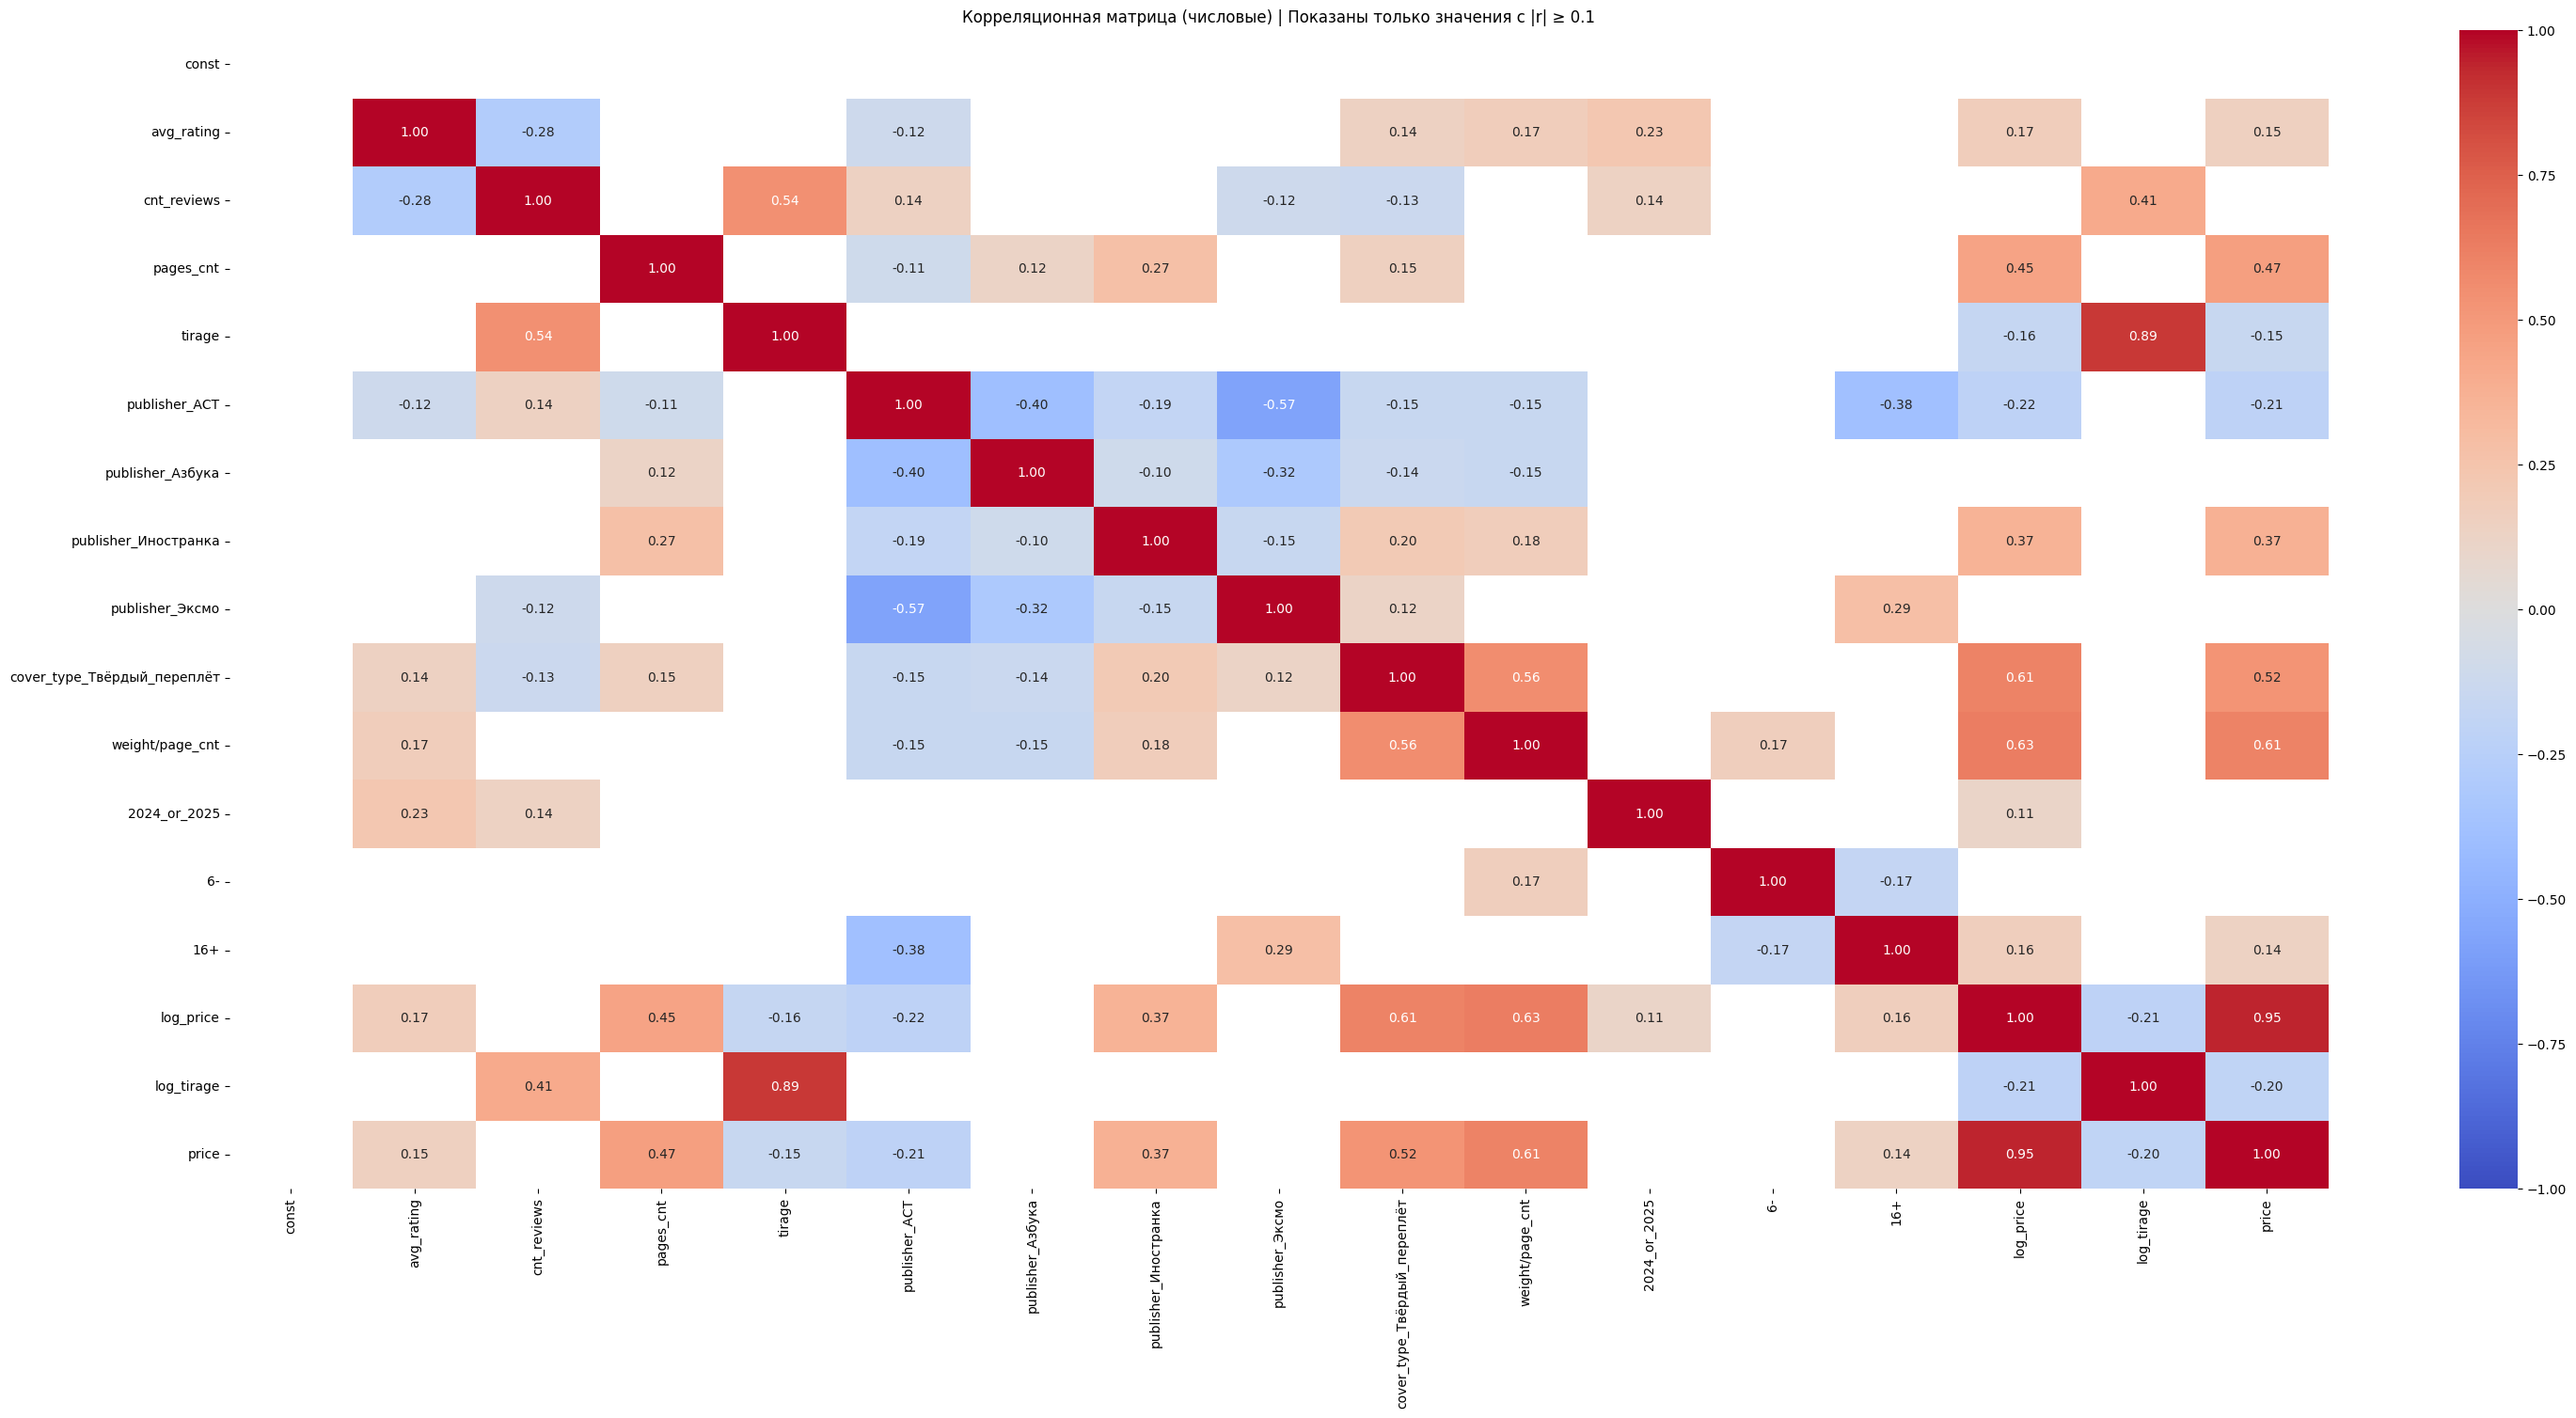

In [23]:
new_data = data.copy()
new_data['price'] = np.exp(data['log_price'])

# Вычисляем матрицу корреляций
corr_matrix = new_data.corr()

# Создаем маску для незначительных значений
mask = np.abs(corr_matrix) < 0.1

plt.figure(figsize=(36, 16))
sns.heatmap(
    corr_matrix,
    mask=mask,          
    annot=True, 
    fmt=".2f", 
    cmap="coolwarm", 
    vmin=-1, 
    vmax=1,
)
plt.title('Корреляционная матрица (числовые) | Показаны только значения с |r| ≥ 0.1')
plt.show()

##### Выбор инструмента

После исследования корреляционной матрицы было принято решение рассмотреть `log_tirage` как инструмент для `reviews_cnt`, так как чем больше книг выпускается в печать, тем больше людей ее их вероятно купят и оставят отзыв. 

$$corr_{\text{log\_price, log\_tirage}} = -0.21$$

$$corr_{\text{cnt\_reviews, log\_tirage}} = 0.41$$

##### Проверим устойчивость модели без тиража

Модель с `log_tirage`

In [24]:
model_logy_log_tirage = sm.OLS(data['log_price'], data.drop(['log_price', 'tirage'], axis=1)).fit()
print(model_logy_log_tirage.summary())

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.730
Model:                            OLS   Adj. R-squared:                  0.729
Method:                 Least Squares   F-statistic:                     660.0
Date:                Thu, 08 May 2025   Prob (F-statistic):               0.00
Time:                        23:32:33   Log-Likelihood:                -243.32
No. Observations:                3190   AIC:                             514.6
Df Residuals:                    3176   BIC:                             599.6
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

Модель с `tirage`

In [25]:
model_logy_tirage = sm.OLS(data['log_price'], data.drop(['log_price', 'log_tirage'], axis=1)).fit()
print(model_logy_tirage.summary())

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.722
Model:                            OLS   Adj. R-squared:                  0.721
Method:                 Least Squares   F-statistic:                     633.5
Date:                Thu, 08 May 2025   Prob (F-statistic):               0.00
Time:                        23:32:34   Log-Likelihood:                -290.70
No. Observations:                3190   AIC:                             609.4
Df Residuals:                    3176   BIC:                             694.3
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

Модель без `tirage` и `log_tirage`

In [26]:
model_logy_no_tirage = sm.OLS(data['log_price'], data.drop(['log_price', 'log_tirage', 'tirage'], axis=1)).fit()
print(model_logy_no_tirage.summary())

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.697
Model:                            OLS   Adj. R-squared:                  0.696
Method:                 Least Squares   F-statistic:                     609.6
Date:                Thu, 08 May 2025   Prob (F-statistic):               0.00
Time:                        23:32:35   Log-Likelihood:                -425.28
No. Observations:                3190   AIC:                             876.6
Df Residuals:                    3177   BIC:                             955.4
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

##### Вывод

$R^2_{adj}$ снижается, но не драматически $\rightarrow$ избавляемся от переменной `tirage`

#### IV модель

* **Гипотеза:** в модели возникает эндогенность из-за наличия обратной связи между Y и X. А конкретнее количество отзывов зависит от цена, то есть `чем меньше цена, тем больше отзывов`.
* **Инструментальная переменная:** `тираж`, как отражение популярности книги.
* **Используемый метод:** IV - метод инструментальных переменных

##### Проверим валидность инструмента `log_tirage`

In [27]:
X = data.drop(['log_price', 'tirage', 'log_tirage', 'cnt_reviews'], axis=1)
y = data['log_price']

iv_model = IV2SLS(
    dependent=data['log_price'],
    exog=X,
    endog=data['cnt_reviews'],
    instruments=data['log_tirage']
).fit()

**Тест Хаусмана**

$H_0: plim_{n \to \infty} \cfrac{X'\epsilon}{n} = 0$ (можно ограничиться обычным OLS)

$H_1: else$ (обычным OLS ограничиться нельзя)

Статистика: 
$$
\eta = (\hat{\beta}_{IV} - \hat{\beta}_{\text{МНК}})' \left( V(\hat{\beta}_{IV}) - V(\hat{\beta}_{\text{МНК}}) \right)^{-1} (\hat{\beta}_{IV} - \hat{\beta}_{\text{МНК}}) \sim \chi^2_k
$$

In [28]:
iv_model.wu_hausman(['cnt_reviews'])

Wu-Hausman test of exogeneity
H0: Variables cnt_reviews are exogenous
Statistic: 383.7903
P-value: 0.0000
Distributed: F(1,3176)
WaldTestStatistic, id: 0x31e9260a0

**Вывод:** $pvalue = 0$, значит нулевая гипотеза отвергается - обычного МНК не хватает. Но неизвестно - это инструмент не валиден, или действительно IV будет лучше

Коэффициент корреляции `log_tirage` с `log_price` $= -0.21$, что может говорить о неэкзогенности инструмента. Тем не менее, корреляция не настолько сильная. За неимением других инструментов продолжим изучать этот.

##### Проверим релевантность инструмента

In [29]:
Z = pd.concat((X, data['log_tirage']), axis=1)

Тестирование проводим так:

Оцениваем регрессию жндогенной переменной на все регрессоры и инструмент. Если F-статистика этой модели > 104.7, то инструмент `релевантен`

In [30]:
dependent = data['cnt_reviews']
exog = Z

mod = sm.OLS(dependent, exog)
res = mod.fit()

print(res.summary())

# # релевантность
# hypotheses = '(log_tirage = 0)'
# f_test = res.f_test(hypotheses)
# print(f'\n{f_test}')

                            OLS Regression Results                            
Dep. Variable:            cnt_reviews   R-squared:                       0.306
Model:                            OLS   Adj. R-squared:                  0.303
Method:                 Least Squares   F-statistic:                     116.6
Date:                Thu, 08 May 2025   Prob (F-statistic):          4.13e-241
Time:                        23:32:38   Log-Likelihood:                -19555.
No. Observations:                3190   AIC:                         3.914e+04
Df Residuals:                    3177   BIC:                         3.921e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

In [31]:
print(f'\nF-статистика первого шага = {res.fvalue}')
print(f'\n{"Инструмент релевантен" if res.fvalue >= 104.7 else "Инструмент не релевантен"}')


F-статистика первого шага = 116.59193831831557

Инструмент релевантен


Инструмент оказался релевантным!

##### Включение инструмента в модель

In [32]:
X_exog = X.copy()

X_exog['cnt_reviews_exog'] = res.fittedvalues
X_exog

,const,avg_rating,pages_cnt,publisher_АСТ,publisher_Азбука,publisher_Иностранка,publisher_Эксмо,cover_type_Твёрдый_переплёт,weight/page_cnt,2024_or_2025,6-,16+,cnt_reviews_exog
0,1.0,4.1,512,1.0,0.0,0.0,0.0,0.0,0.488281,1.0,0.0,1.0,376.521735
1,1.0,4.1,320,1.0,0.0,0.0,0.0,0.0,0.625000,1.0,0.0,1.0,377.026948
2,1.0,4.5,192,1.0,0.0,0.0,0.0,0.0,0.687500,1.0,0.0,1.0,316.054884
3,1.0,4.3,288,1.0,0.0,0.0,0.0,0.0,0.725694,1.0,0.0,1.0,257.481046
4,1.0,4.2,320,1.0,0.0,0.0,0.0,0.0,0.625000,1.0,0.0,1.0,366.877061
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3185,1.0,5.0,624,0.0,0.0,0.0,1.0,1.0,1.538462,0.0,0.0,1.0,-134.933105
3186,1.0,3.7,448,0.0,0.0,0.0,1.0,1.0,1.696429,0.0,0.0,1.0,-1.822915
3187,1.0,4.3,784,0.0,0.0,1.0,0.0,1.0,1.096939,0.0,0.0,1.0,84.392983
3188,1.0,3.8,704,0.0,0.0,0.0,1.0,1.0,0.906250,0.0,0.0,1.0,6.054036


#### Оценка IV модели

In [33]:
exog_model = sm.OLS(y, X_exog).fit()
exog_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.719
Model:                            OLS   Adj. R-squared:                  0.718
Method:                 Least Squares   F-statistic:                     677.6
Date:                Thu, 08 May 2025   Prob (F-statistic):               0.00
Time:                        23:32:39   Log-Likelihood:                -305.81
No. Observations:                3190   AIC:                             637.6
Df Residuals:                    3177   BIC:                             716.5
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                           5.5164      0.079     69.521      0.000       5.361       5.672
avg_rating                     -0.1217      0.016     -7.400      0.000      -0.154      -0.089
pages_cnt                       0.0009   2.32e-05     40.807      0.000       0.001       0.001
publisher_АСТ                   0.0093      0.026      0.364      0.716      -0.041       0.060
publisher_Азбука               -0.0323      0.027     -1.190      0.234      -0.085       0.021
publisher_Иностранка            0.3333      0.033      9.979      0.000       0.268       0.399
publisher_Эксмо                -0.0364      0.025     -1.429      0.153      -0.086       0.014
cover_type_Твёрдый_переплёт     0.1994      0.012     16.321      0.000       0.175       0.223
weight/page_cnt                 0.6626      0.017     39.768      0.000       0.630       0.695
2024_or_2025                    0.1347      0.012     11.126      0.000       0.111       0.158
6-                              0.1403      0.056      2.525      0.012       0.031       0.249
16+                             0.1009      0.013      7.819      0.000       0.076       0.126
cnt_reviews_exog               -0.0015    9.1e-05    -16.046      0.000      -0.002      -0.001
==============================================================================
Omnibus:                      767.816   Durbin-Watson:                   1.965
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5166.273
Skew:                          -0.970   Prob(JB):                         0.00
Kurtosis:                       8.925   Cond. No.                     9.14e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.14e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Тест Уайта

In [34]:
# Тест Уайта
residuals = exog_model.resid
white_test = het_white(residuals, X_exog)

lm_stat, lm_pval, f_stat, f_pval = white_test

print(f"LM-статистика: {lm_stat}")
print(f"p-value для LM-статистики: {lm_pval}")
print(f"F-статистика: {f_stat}")
print(f"p-value для F-статистики: {f_pval}")

if lm_pval < 0.05:
    print("Гетероскедастичность выявлена.")
else:
    print("Нет признаков гетероскедастичности.")

LM-статистика: 2416.36168335165
p-value для LM-статистики: 0.0
F-статистика: 133.3209986243774
p-value для F-статистики: 0.0
Гетероскедастичность выявлена.


Тест Уайта все равно говорит о гетероскедастичности. Теперь попробуем бороться направленно с ней

## Попытки убрать гетероскедастичность:

In [35]:
# X = sm.add_constant(data.drop(columns='log_price'))
X = X_exog.copy()
y = data['log_price']

ols_model = sm.OLS(y, X).fit()
residuals = ols_model.resid

for col in data.columns.drop('log_price').drop('const'):
    X_j = sm.add_constant(data[[col]])
    model = sm.OLS(np.abs(residuals), X_j).fit()
    print(f"{col} p-value = {round(model.pvalues[1], 4)}")

avg_rating p-value = 0.5206
cnt_reviews p-value = 0.8635
pages_cnt p-value = 0.0001
tirage p-value = 0.0
publisher_АСТ p-value = 0.0
publisher_Азбука p-value = 0.0004
publisher_Иностранка p-value = 0.0
publisher_Эксмо p-value = 0.0
cover_type_Твёрдый_переплёт p-value = 0.0
weight/page_cnt p-value = 0.0
2024_or_2025 p-value = 0.2055
6- p-value = 0.0015
16+ p-value = 0.2074
log_tirage p-value = 0.0001


### 1) Реализация WLS из пакета

`Актуально и для FGLS:`<br>
Если предполагается, что дисперсия ошибки зависит от уровня прогнозируемого значения (например, остатки растут с увеличением `y_hat`), то надо использовать такую вспомогательную модель:
* aux_model = sm.OLS(np.abs(resid), sm.add_constant(y_pred)).fit()

Более общей вспомогательной моделью является:
* aux_model_1 = sm.OLS(np.abs(resid), X_upd).fit()


In [59]:
exog_model = sm.OLS(y, X_exog).fit()
resid = exog_model.resid

aux_model = sm.OLS(np.abs(resid), X_exog).fit()
sigma_hat = aux_model.fittedvalues

# ручная реализация
y_wls = y / sigma_hat
X_wls = X_exog.copy()
X_wls = X_wls.div(sigma_hat, axis=0)

# из пакета
wls_model = sm.WLS(y, X_exog, weights=1/sigma_hat**2)
wls_result = wls_model.fit()

wls_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.975
Model:                            WLS   Adj. R-squared:                  0.975
Method:                 Least Squares   F-statistic:                 1.042e+04
Date:                Thu, 08 May 2025   Prob (F-statistic):               0.00
Time:                        23:41:24   Log-Likelihood:                -160.39
No. Observations:                3190   AIC:                             346.8
Df Residuals:                    3177   BIC:                             425.7
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                           5.4834      0.036    151.343      0.000       5.412       5.554
avg_rating                     -0.0583      0.009     -6.705      0.000      -0.075      -0.041
pages_cnt                       0.0007   1.73e-05     40.082      0.000       0.001       0.001
publisher_АСТ                   0.0226      0.011      2.026      0.043       0.001       0.044
publisher_Азбука               -0.0271      0.010     -2.603      0.009      -0.048      -0.007
publisher_Иностранка            0.2989      0.014     21.889      0.000       0.272       0.326
publisher_Эксмо                -0.0124      0.012     -1.015      0.310      -0.036       0.012
cover_type_Твёрдый_переплёт     0.3856      0.010     37.667      0.000       0.366       0.406
weight/page_cnt                 0.4072      0.017     23.326      0.000       0.373       0.441
2024_or_2025                    0.0399      0.008      4.737      0.000       0.023       0.056
6-                              0.0358      0.046      0.779      0.436      -0.054       0.126
16+                             0.0344      0.005      7.616      0.000       0.026       0.043
cnt_reviews_exog               -0.0003   5.13e-05     -6.191      0.000      -0.000      -0.000
==============================================================================
Omnibus:                      827.393   Durbin-Watson:                   2.037
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            20925.042
Skew:                           0.650   Prob(JB):                         0.00
Kurtosis:                      15.480   Cond. No.                     1.69e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.69e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [60]:
# Тест Уайта
X_wls_for_test = X_exog

residuals = wls_result.resid

white_test = het_white(residuals, X_wls_for_test)

lm_stat, lm_pval, f_stat, f_pval = white_test

print(f"LM-статистика: {lm_stat}")
print(f"p-value для LM-статистики: {lm_pval}")
print(f"F-статистика: {f_stat}")
print(f"p-value для F-статистики: {f_pval}")

if lm_pval < 0.05:
    print("Гетероскедастичность выявлена.")
else:
    print("Нет признаков гетероскедастичности.")

LM-статистика: 1368.023728387841
p-value для LM-статистики: 6.522499338426076e-238
F-статистика: 32.04981319230367
p-value для F-статистики: 5.061e-320
Гетероскедастичность выявлена.


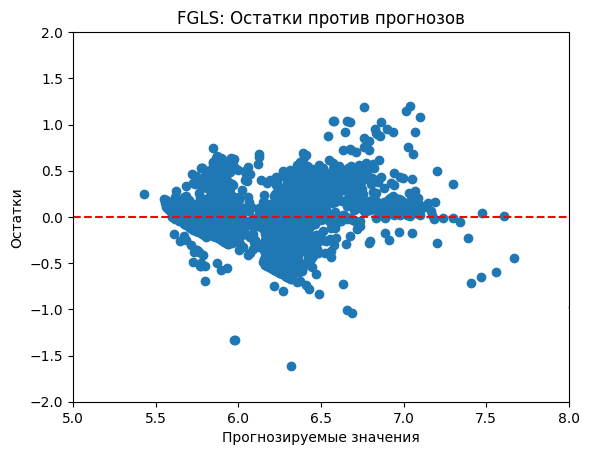

In [61]:
plt.scatter(wls_result.fittedvalues, wls_result.resid)
plt.axhline(0, color='red', linestyle='--')
plt.xlim(xmax=8, xmin=5)
plt.ylim(ymax=2, ymin=-2)
plt.xlabel('Прогнозируемые значения')
plt.ylabel('Остатки')
plt.title('FGLS: Остатки против прогнозов')
plt.show()

### 2) Имплементация робастных ошибок в форме Уайта:

* `HC0` — классический White

* `HC1` — скорректированный White (умножается на n/(n−k))

* `HC2`, `HC3` — ещё более устойчивые, особенно при небольших выборках

При наличии в выборке выбросов – наблюдений, сильно
отличающихся от остальных, используют поправки:
* **`HC2`**
* **`HC3`**
<br>

Исследования показывают, что на конечных выборках
**`HC2`** и **`HС3`** дают более точные результаты, чем **`HC1`**.

In [62]:
log_model_robust = sm.OLS(data['log_price'], X_exog).fit(cov_type='HC2')

print(log_model_robust.summary())

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.719
Model:                            OLS   Adj. R-squared:                  0.718
Method:                 Least Squares   F-statistic:                     1245.
Date:                Thu, 08 May 2025   Prob (F-statistic):               0.00
Time:                        23:41:28   Log-Likelihood:                -305.81
No. Observations:                3190   AIC:                             637.6
Df Residuals:                    3177   BIC:                             716.5
Df Model:                          12                                         
Covariance Type:                  HC2                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

In [63]:
# Тест Уайта
X_wls_for_test = X_exog

residuals = log_model_robust.resid

white_test = het_white(residuals, X_wls_for_test)

lm_stat, lm_pval, f_stat, f_pval = white_test

print(f"LM-статистика: {lm_stat}")
print(f"p-value для LM-статистики: {lm_pval}")
print(f"F-статистика: {f_stat}")
print(f"p-value для F-статистики: {f_pval}")

if lm_pval < 0.05:
    print("Гетероскедастичность выявлена.")
else:
    print("Нет признаков гетероскедастичности.")

LM-статистика: 2416.36168335165
p-value для LM-статистики: 0.0
F-статистика: 133.3209986243774
p-value для F-статистики: 0.0
Гетероскедастичность выявлена.


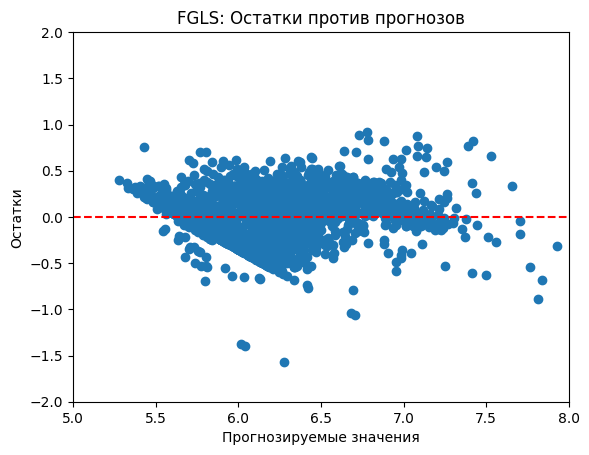

In [64]:
plt.scatter(log_model_robust.fittedvalues, log_model_robust.resid)
plt.axhline(0, color='red', linestyle='--')
plt.xlim(xmax=8, xmin=5)
plt.ylim(ymax=2, ymin=-2)
plt.xlabel('Прогнозируемые значения')
plt.ylabel('Остатки')
plt.title('FGLS: Остатки против прогнозов')
plt.show()

# Вывод

Лучшей моделью оказалась WLS модель

In [65]:
wls_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.975
Model:                            WLS   Adj. R-squared:                  0.975
Method:                 Least Squares   F-statistic:                 1.042e+04
Date:                Thu, 08 May 2025   Prob (F-statistic):               0.00
Time:                        23:43:43   Log-Likelihood:                -160.39
No. Observations:                3190   AIC:                             346.8
Df Residuals:                    3177   BIC:                             425.7
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                           5.4834      0.036    151.343      0.000       5.412       5.554
avg_rating                     -0.0583      0.009     -6.705      0.000      -0.075      -0.041
pages_cnt                       0.0007   1.73e-05     40.082      0.000       0.001       0.001
publisher_АСТ                   0.0226      0.011      2.026      0.043       0.001       0.044
publisher_Азбука               -0.0271      0.010     -2.603      0.009      -0.048      -0.007
publisher_Иностранка            0.2989      0.014     21.889      0.000       0.272       0.326
publisher_Эксмо                -0.0124      0.012     -1.015      0.310      -0.036       0.012
cover_type_Твёрдый_переплёт     0.3856      0.010     37.667      0.000       0.366       0.406
weight/page_cnt                 0.4072      0.017     23.326      0.000       0.373       0.441
2024_or_2025                    0.0399      0.008      4.737      0.000       0.023       0.056
6-                              0.0358      0.046      0.779      0.436      -0.054       0.126
16+                             0.0344      0.005      7.616      0.000       0.026       0.043
cnt_reviews_exog               -0.0003   5.13e-05     -6.191      0.000      -0.000      -0.000
==============================================================================
Omnibus:                      827.393   Durbin-Watson:                   2.037
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            20925.042
Skew:                           0.650   Prob(JB):                         0.00
Kurtosis:                      15.480   Cond. No.                     1.69e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.69e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [66]:
wls_result.params

const                          5.483409
avg_rating                    -0.058277
pages_cnt                      0.000692
publisher_АСТ                  0.022585
publisher_Азбука              -0.027127
publisher_Иностранка           0.298873
publisher_Эксмо               -0.012373
cover_type_Твёрдый_переплёт    0.385583
weight/page_cnt                0.407199
2024_or_2025                   0.039925
6-                             0.035841
16+                            0.034402
cnt_reviews_exog              -0.000317
dtype: float64

# Предсказание для конретного объекта

In [83]:
X_test = pd.DataFrame([{
    'const': 1,
    'avg_rating': 4.3,
    'pages_cnt': 320,
    'publisher_АСТ': 0,
    'publisher_Азбука': 1,
    'publisher_Иностранка': 0,
    'publisher_Эксмо': 0,
    'cover_type_Твёрдый_переплёт': 1,
    'weight/page_cnt': 3.1,
    '2024_or_2025': 1,
    '6-': 0,
    '16+': 1,
    'log_tirage': np.log(5000),
    'cnt_reviews': 158
}])

In [90]:
cnt_reviews_exog_test = res.predict(X_test.drop(columns=['cnt_reviews']))

X_test['cnt_reviews_exog'] = cnt_reviews_exog_test

cnt_reviews_exog_test

0    160.61714
dtype: float64

In [102]:
pred_test = exog_model.predict(X_test.drop(columns=["cnt_reviews", "log_tirage"])).values[0]

print(f'Предсказанное значение для конкретного объекта: {round(pred_test, 2)}')
print(f'То есть цена в рублях: {round(np.exp(pred_test), 2)} рублей')

Предсказанное значение для конкретного объекта: 7.52
То есть цена в рублях: 1841.61 рублей


Цена высокая, но это логично, так как страницы долвольно тяжелые: weight / pages_cnt = 3.1, значит книга дорогая в производстве